# Multimodal Factorization Model - CMU-MOSI Dataset

In this notebook, we implement the Multimodal Factorization Model, and test it on CMU-MOSI dataset.

## Importing Libraries

In [1]:
import os
import sys
import torch
from torch import nn

import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.getcwd())
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

## Importing Helper Functions

In [2]:
from helpers.data.get_data import get_dataloader
from helpers.unimodals.common_models import MLP
from helpers.unimodals.MVAE import TSEncoder, TSDecoder
from helpers.unimodals.helper_modules import Sequential2
from helpers.objective_functions.objectives_for_supervised_learning import MFM_objective
from helpers.training.supervised_learning import train, test
from helpers.fusions.common_fusions import Concat
from helpers.utils.common_utils import get_default_device, save_results

## Loading the Dataset

In [3]:
classes = 2
n_latent = 256
dim_0 = 35
dim_1 = 74
dim_2 = 300
timestep = 50

In [4]:
traindata, validdata, testdata = get_dataloader(
    '/scratch/rrm9598/data/mosi_raw.pkl', task='classification', robust_test=False, max_pad=True, max_seq_len=timestep)

In [5]:
device = get_default_device()
print(device)

cuda


## Model Architecture

In [6]:
encoders = [
    TSEncoder(dim_0, 30, n_latent, timestep, returnvar=False).to(device),
    TSEncoder(dim_1, 30, n_latent, timestep, returnvar=False).to(device), 
    TSEncoder(dim_2, 30, n_latent, timestep, returnvar=False).to(device)
]

decoders = [
    TSDecoder(dim_0, 30, n_latent, timestep).to(device), 
    TSDecoder(dim_1, 30, n_latent, timestep).to(device), 
    TSDecoder(dim_2, 30, n_latent, timestep).to(device)
]

fuse = Sequential2(
    Concat(), 
    MLP(3*n_latent, n_latent, n_latent//2)
).to(device)

intermediates = [
    MLP(n_latent, n_latent//2, n_latent//2).to(device), 
    MLP(n_latent, n_latent//2, n_latent//2).to(device), 
    MLP(n_latent, n_latent//2, n_latent//2).to(device)
]

head = MLP(n_latent//2, 20, classes).to(device)

argsdict = {'decoders': decoders, 'intermediates': intermediates}

additional_modules = decoders + intermediates

objective = MFM_objective(
    2.0, 
    [torch.nn.MSELoss(), 
     torch.nn.MSELoss(), 
     torch.nn.MSELoss()], 
    [1.0, 1.0, 1.0]
)

## Training

In [7]:
FILE_NAME = 'mosi_mfm_r0'

In [8]:
train_losses, valid_losses = train(
    encoders, fuse, head, traindata, validdata, 200, additional_modules,
    objective=objective, objective_args_dict=argsdict, save=f'/scratch/rrm9598/Multimodal-Sentiment-Analysis/models/{FILE_NAME}.pt'
)

Epoch [1/200]
Train Loss: 106.6944
Valid Loss: 80.0442 | Accuracy: 42.5234%
Saving Best

Epoch [2/200]
Train Loss: 72.1197
Valid Loss: 220.2112 | Accuracy: 42.5234%

Epoch [3/200]
Train Loss: 103.4236
Valid Loss: 220.8858 | Accuracy: 42.5234%

Epoch [4/200]
Train Loss: 123.8407
Valid Loss: 135.8064 | Accuracy: 53.7383%
Saving Best

Epoch [5/200]
Train Loss: 79.7526
Valid Loss: 58.5560 | Accuracy: 57.4766%
Saving Best

Epoch [6/200]
Train Loss: 118.8055
Valid Loss: 207.8120 | Accuracy: 52.3364%

Epoch [7/200]
Train Loss: 117.2001
Valid Loss: 124.5396 | Accuracy: 57.4766%

Epoch [8/200]
Train Loss: 85.3727
Valid Loss: 67.5601 | Accuracy: 57.9439%
Saving Best

Epoch [9/200]
Train Loss: 55.3393
Valid Loss: 84.8848 | Accuracy: 54.6729%

Epoch [10/200]
Train Loss: 50.3602
Valid Loss: 42.0349 | Accuracy: 57.9439%

Epoch [11/200]
Train Loss: 88.4969
Valid Loss: 59.4075 | Accuracy: 57.0093%

Epoch [12/200]
Train Loss: 51.2908
Valid Loss: 36.9871 | Accuracy: 57.4766%

Epoch [13/200]
Train Loss: 

Text(0.5, 1.0, 'Loss vs. No. of epochs')

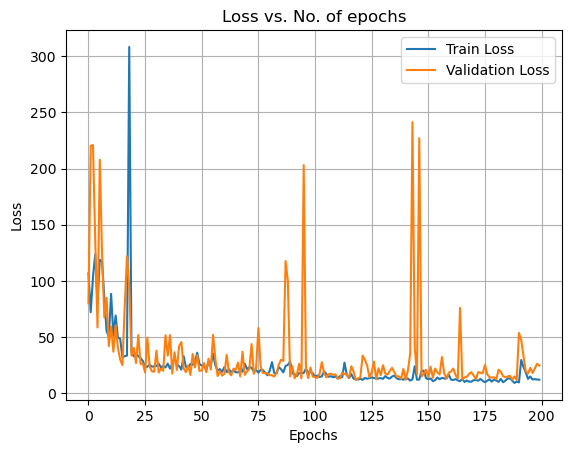

In [9]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs')

In [10]:
save_results(train_losses, valid_losses, f'/scratch/rrm9598/Multimodal-Sentiment-Analysis/results/{FILE_NAME}.pkl')

## Testing

In [11]:
model = torch.load(f'/scratch/rrm9598/Multimodal-Sentiment-Analysis/models/{FILE_NAME}.pt').to(device)

test(model, test_dataloaders_all=testdata, dataset='mosi', is_packed=False, no_robust=True)

Accuracy: 66.4723%
Inference Time: 496ms
Inference Params: 1430600
